### https://github.com/201710757/deepL.git

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [2]:
mnist_train = dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

mnist train 길이 :  60000
mnist test 길이 :  10000
Image data 형태 :  torch.Size([1, 28, 28])
Label :  5


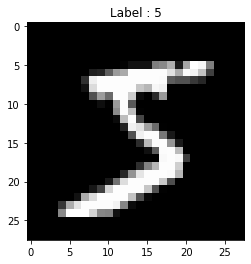

In [3]:
print("mnist train 길이 : ", len(mnist_train))
print("mnist test 길이 : ", len(mnist_test))

image, label = mnist_train.__getitem__(0)
print("Image data 형태 : ", image.size())
print("Label : ", label)

img = image.numpy()
plt.title("Label : %d"%label)
plt.imshow(img[0], cmap='gray')
plt.show()

5
torch.Size([1, 28, 28])
5


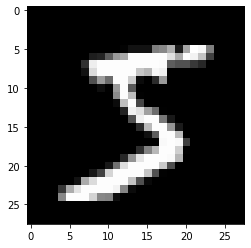

0


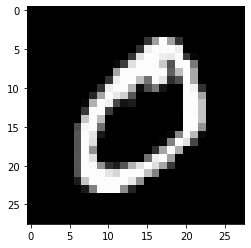

4


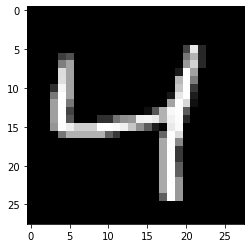

In [4]:
print(mnist_train[0][1])
print(mnist_train[0][0].size())

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0], cmap='gray')
    plt.show()

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


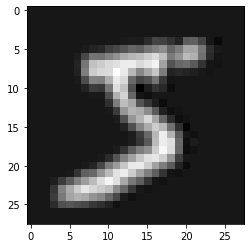

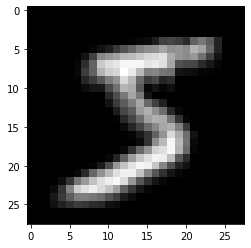

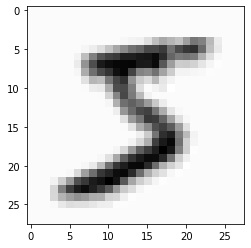

In [5]:
image, label = mnist_train[0]
image = image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())
print(label)

conv_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
output = conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()

In [6]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate=0.0002
num_epoch=10

train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size,
                                          shuffle=False, num_workers=2, drop_last=True)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
                        nn.Conv2d(1,16,5, padding=2),
                        nn.ReLU(),
            
                        nn.Conv2d(16,32,5, padding=2),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2),
            
            
                        nn.Conv2d(32,64,5, padding=2),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2),
                    )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out
    
model = CNN().cuda()

In [8]:
for parameter in model.parameters():
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [9]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_ = Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j%50 == 0:
            print(loss, j, i)

tensor(2.3145, device='cuda:0', grad_fn=<NllLossBackward>) 0 0
tensor(1.6041, device='cuda:0', grad_fn=<NllLossBackward>) 50 0
tensor(0.6098, device='cuda:0', grad_fn=<NllLossBackward>) 0 1
tensor(0.6472, device='cuda:0', grad_fn=<NllLossBackward>) 50 1
tensor(0.5691, device='cuda:0', grad_fn=<NllLossBackward>) 0 2
tensor(0.5038, device='cuda:0', grad_fn=<NllLossBackward>) 50 2
tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward>) 0 3
tensor(0.4899, device='cuda:0', grad_fn=<NllLossBackward>) 50 3
tensor(0.1579, device='cuda:0', grad_fn=<NllLossBackward>) 0 4
tensor(0.2799, device='cuda:0', grad_fn=<NllLossBackward>) 50 4
tensor(0.0509, device='cuda:0', grad_fn=<NllLossBackward>) 0 5
tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward>) 50 5
tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward>) 0 6
tensor(0.2100, device='cuda:0', grad_fn=<NllLossBackward>) 50 6
tensor(0.1327, device='cuda:0', grad_fn=<NllLossBackward>) 0 7
tensor(0.2613, device='cuda:0', grad_fn=<NllLoss

In [11]:
torch.save(model, './nets/cnn_mnist_%d.pkl'%(num_epoch))

In [12]:
try:
    model = torch.load('./nets/cnn_mnist_10.pkl')
    print("model restored")
except Exception as e:
    print(e)

model restored


In [13]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs).cuda()
        label = Variable(labels).cuda()
        
        output = imodel.forward(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Acc of Test data : {}".format((100*correct/total).floor()))

In [14]:
ComputeAccr(test_loader, model)

Acc of Test data : 94.0
